# YogaPartner

Our datasets are in
- `.\data\v1`
- `.\data\v2`

Our frontend code is in `.\android`

Our generated data goes in `.\intermediates`

Our augmented data goes in `.\aug`

Our models go in `.\models`

In [3]:
import os
from pathlib import Path
import re
import tqdm
import shutil
import time
import math

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from PIL import Image
import cv2

from difPy import dif

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.nn import relu6
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import mediapipe as mp
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

## Global functions

In [4]:
version = 2
def getPath():
    return r".\data\v" + str(version)

def getClasses():
    path = getPath()
    return os.listdir(path)

def getPathOfClass(className):
    path = getPath()
    return os.path.join(path, className)

intermediates_dir = r".\intermediates\v" + str(version)
classFolders = getClasses()

## Dataset stats

In [3]:
def visualizeDataSet():
    counts = []
    imageTypes = {}
    for classFolder in classFolders:
        images = os.listdir(getPathOfClass(classFolder))
        count = len(images)
        counts.append(count)
        for image in images:
            image_path = os.path.join(getPathOfClass(classFolder), image)
            p = Path(image_path)
            ext = p.suffix
            imageTypes[ext] = imageTypes.get(ext, 0) + 1

    print("Dataset frequency distribution")
    for i in range(len(classFolders)):
        className = classFolders[i]
        count = counts[i]
        print(className + " : " + str(count))

    print()

    print("Image type frequency distribution")
    for key in imageTypes.keys():
        count = imageTypes[key]
        print(key + " : " + str(count))

    print()
    
visualizeDataSet()

Dataset frequency distribution
adho_mukha_shvanasana : 428
bhujangasana : 511
bidalasana : 307
phalakasana : 192
ustrasana : 197
utkatasana : 202
utkata_konasana : 108
virabhadrasana_i : 211
virabhadrasana_ii : 361
vrikshasana : 124

Image type frequency distribution
.jpg : 2601
.jpeg : 40



## Cleaning Data

### Convert to Jpeg

In [4]:
for className in classFolders:
    class_path = getPathOfClass(className)
    files = os.listdir(class_path)
    for f in files:
        old_path = os.path.join(class_path, f)
        p = Path(old_path)
        ext = p.suffix
        if ext == ".webp":
            print("Converting " + f)
            new_file_name = f"{p.stem}.jepg"
            im = Image.open(old_path).convert("RGB")
            new_file_path = os.path.join(class_path, new_file_name)
            print(new_file_path)
            im.save(new_file_path, "jepg")
            print("Removing " + f)
            os.remove(old_path)
        if ext == ".png":
            print("Converting " + f)
            new_file_name = f"{p.stem}.jpg"
            im = Image.open(old_path).convert("RGB")
            new_file_path = os.path.join(class_path, new_file_name)
            print(new_file_path)
            im.save(new_file_path)
            print("Removing " + f)
            os.remove(old_path)
        if ext == ".JPG":
            print("Converting " + f)
            new_file_name = f"{p.stem}.jpg"
            im = Image.open(old_path).convert("RGB")
            new_file_path = os.path.join(class_path, new_file_name)
            print(new_file_path)
            im.save(new_file_path)
            print("Removing " + f)
            os.remove(old_path)
print("Converted Webp and PNG")

Converted Webp and PNG


### Finding duplicate images

In [5]:
for className in tqdm.tqdm(classFolders, position=0):
    class_path = getPathOfClass(className)
    search = dif(class_path, delete=True)
print("Completed duplicate image search")

 10%|████████▎                                                                          | 1/10 [00:38<05:42, 38.11s/it]

Found 0 images with one or more duplicate/similar images in 38.1057 seconds.


 20%|████████████████▌                                                                  | 2/10 [01:33<06:28, 48.51s/it]

Found 0 images with one or more duplicate/similar images in 55.79 seconds.


 30%|████████████████████████▉                                                          | 3/10 [01:54<04:10, 35.80s/it]

Found 0 images with one or more duplicate/similar images in 20.6722 seconds.


 40%|█████████████████████████████████▏                                                 | 4/10 [02:05<02:35, 25.90s/it]

Found 0 images with one or more duplicate/similar images in 10.711 seconds.


 50%|█████████████████████████████████████████▌                                         | 5/10 [02:14<01:38, 19.70s/it]

Found 0 images with one or more duplicate/similar images in 8.7126 seconds.


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:24<01:05, 16.43s/it]

Found 0 images with one or more duplicate/similar images in 10.0762 seconds.


 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:29<00:38, 12.98s/it]

Found 0 images with one or more duplicate/similar images in 5.8848 seconds.
Found 1 image with one or more duplicate/similar images in 11.1498 seconds.
Are you sure you want to delete all lower resolution duplicate images? 
This cannot be undone. (y/n)y


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [02:44<00:26, 13.44s/it]


Deleted file: .\data\v2\virabhadrasana_i/virabhadrasana_ii_191.jpg
***
Deleted 1 images.


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [03:15<00:19, 19.05s/it]

Found 0 images with one or more duplicate/similar images in 31.3894 seconds.


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:22<00:00, 20.27s/it]

Found 0 images with one or more duplicate/similar images in 6.9307 seconds.
Completed duplicate image search


### Cleaning up folder names

In [6]:
for className in classFolders:
    old_path = getPathOfClass(className)
    new_name = re.sub(r"\s+", "_", className)
    if new_name != className:
        print("Renaming " + className)
    new_path = os.path.join(getPath(), new_name)
    os.rename(old_path, new_path)
print("Renamed class names")

Renamed class names


### Removing non supported images

In [7]:
for className in classFolders:
    class_path = getPathOfClass(className)
    files = os.listdir(class_path)
    count = 1
    for f in files:
        f_path = os.path.join(class_path, f)
        if not (f.endswith(".jpg") or f.endswith(".jpeg")):
            os.remove(f_path)
            print("Removed " + f)
print("Finished removing non suporrted images")

Finished removing non suporrted images


### Cleaning up file names

In [26]:
for className in classFolders:
    class_path = getPathOfClass(className)
    files = os.listdir(class_path)
    count = 1
    for f in files:
        old_path = os.path.join(class_path, f)
        p = Path(old_path)
        new_file_name = f"{className}_{count}{p.suffix}"
        if new_file_name != f:
            print("Renaming " + f)
        new_file_path = os.path.join(class_path, new_file_name)
        if(os.path.exists(new_file_path)):
            print("Clash in names, change to unique pattern")
            break
        os.rename(old_path, new_file_path)
        count += 1
        
print("Finished cleaning file names")

Renaming adho_mukha_shvanasana_sdasdasdadad_1.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_10.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_100.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_101.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_102.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_103.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_104.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_105.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_106.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_107.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_108.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_109.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_11.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_110.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_111.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_112.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_113.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_114.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_115.jpg
Renaming adho_mu

Renaming adho_mukha_shvanasana_sdasdasdadad_244.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_245.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_246.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_247.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_248.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_249.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_25.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_250.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_251.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_252.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_253.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_254.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_255.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_256.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_257.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_258.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_259.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_26.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_260.jpg
Renaming adho_

Renaming adho_mukha_shvanasana_sdasdasdadad_64.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_65.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_66.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_67.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_68.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_69.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_7.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_70.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_71.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_72.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_73.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_74.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_75.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_76.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_77.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_78.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_79.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_8.jpg
Renaming adho_mukha_shvanasana_sdasdasdadad_80.jpg
Renaming adho_mukha_shvanasana_sd

Renaming bhujangasana_sdasdasdadad_33.jpg
Renaming bhujangasana_sdasdasdadad_330.jpg
Renaming bhujangasana_sdasdasdadad_331.jpg
Renaming bhujangasana_sdasdasdadad_332.jpg
Renaming bhujangasana_sdasdasdadad_333.jpg
Renaming bhujangasana_sdasdasdadad_334.jpg
Renaming bhujangasana_sdasdasdadad_335.jpg
Renaming bhujangasana_sdasdasdadad_336.jpg
Renaming bhujangasana_sdasdasdadad_337.jpg
Renaming bhujangasana_sdasdasdadad_338.jpg
Renaming bhujangasana_sdasdasdadad_339.jpg
Renaming bhujangasana_sdasdasdadad_34.jpg
Renaming bhujangasana_sdasdasdadad_340.jpg
Renaming bhujangasana_sdasdasdadad_341.jpg
Renaming bhujangasana_sdasdasdadad_342.jpg
Renaming bhujangasana_sdasdasdadad_343.jpg
Renaming bhujangasana_sdasdasdadad_344.jpg
Renaming bhujangasana_sdasdasdadad_345.jpg
Renaming bhujangasana_sdasdasdadad_346.jpg
Renaming bhujangasana_sdasdasdadad_347.jpg
Renaming bhujangasana_sdasdasdadad_348.jpg
Renaming bhujangasana_sdasdasdadad_349.jpg
Renaming bhujangasana_sdasdasdadad_35.jpg
Renaming bhuja

Renaming bidalasana_sdasdasdadad_102.jpg
Renaming bidalasana_sdasdasdadad_103.jpg
Renaming bidalasana_sdasdasdadad_104.jpg
Renaming bidalasana_sdasdasdadad_105.jpg
Renaming bidalasana_sdasdasdadad_106.jpg
Renaming bidalasana_sdasdasdadad_107.jpeg
Renaming bidalasana_sdasdasdadad_108.jpg
Renaming bidalasana_sdasdasdadad_109.jpeg
Renaming bidalasana_sdasdasdadad_11.jpg
Renaming bidalasana_sdasdasdadad_110.jpg
Renaming bidalasana_sdasdasdadad_111.jpg
Renaming bidalasana_sdasdasdadad_112.jpg
Renaming bidalasana_sdasdasdadad_113.jpg
Renaming bidalasana_sdasdasdadad_114.jpg
Renaming bidalasana_sdasdasdadad_115.jpg
Renaming bidalasana_sdasdasdadad_116.jpg
Renaming bidalasana_sdasdasdadad_117.jpeg
Renaming bidalasana_sdasdasdadad_118.jpeg
Renaming bidalasana_sdasdasdadad_119.jpg
Renaming bidalasana_sdasdasdadad_12.jpg
Renaming bidalasana_sdasdasdadad_120.jpg
Renaming bidalasana_sdasdasdadad_121.jpg
Renaming bidalasana_sdasdasdadad_122.jpg
Renaming bidalasana_sdasdasdadad_123.jpg
Renaming bidal

Renaming bidalasana_sdasdasdadad_3.jpg
Renaming bidalasana_sdasdasdadad_30.jpg
Renaming bidalasana_sdasdasdadad_31.jpg
Renaming bidalasana_sdasdasdadad_32.jpg
Renaming bidalasana_sdasdasdadad_33.jpg
Renaming bidalasana_sdasdasdadad_34.jpg
Renaming bidalasana_sdasdasdadad_35.jpg
Renaming bidalasana_sdasdasdadad_36.jpg
Renaming bidalasana_sdasdasdadad_37.jpg
Renaming bidalasana_sdasdasdadad_38.jpg
Renaming bidalasana_sdasdasdadad_39.jpg
Renaming bidalasana_sdasdasdadad_4.jpg
Renaming bidalasana_sdasdasdadad_40.jpg
Renaming bidalasana_sdasdasdadad_41.jpg
Renaming bidalasana_sdasdasdadad_42.jpg
Renaming bidalasana_sdasdasdadad_43.jpg
Renaming bidalasana_sdasdasdadad_44.jpg
Renaming bidalasana_sdasdasdadad_45.jpg
Renaming bidalasana_sdasdasdadad_46.jpg
Renaming bidalasana_sdasdasdadad_47.jpg
Renaming bidalasana_sdasdasdadad_48.jpg
Renaming bidalasana_sdasdasdadad_49.jpg
Renaming bidalasana_sdasdasdadad_5.jpeg
Renaming bidalasana_sdasdasdadad_50.jpg
Renaming bidalasana_sdasdasdadad_51.jpeg
R

Renaming ustrasana_sdasdasdadad_52.jpg
Renaming ustrasana_sdasdasdadad_53.jpg
Renaming ustrasana_sdasdasdadad_54.jpg
Renaming ustrasana_sdasdasdadad_55.jpg
Renaming ustrasana_sdasdasdadad_56.jpg
Renaming ustrasana_sdasdasdadad_57.jpg
Renaming ustrasana_sdasdasdadad_58.jpg
Renaming ustrasana_sdasdasdadad_59.jpg
Renaming ustrasana_sdasdasdadad_6.jpg
Renaming ustrasana_sdasdasdadad_60.jpg
Renaming ustrasana_sdasdasdadad_61.jpg
Renaming ustrasana_sdasdasdadad_62.jpg
Renaming ustrasana_sdasdasdadad_63.jpg
Renaming ustrasana_sdasdasdadad_64.jpg
Renaming ustrasana_sdasdasdadad_65.jpg
Renaming ustrasana_sdasdasdadad_66.jpg
Renaming ustrasana_sdasdasdadad_67.jpg
Renaming ustrasana_sdasdasdadad_68.jpg
Renaming ustrasana_sdasdasdadad_69.jpg
Renaming ustrasana_sdasdasdadad_7.jpg
Renaming ustrasana_sdasdasdadad_70.jpg
Renaming ustrasana_sdasdasdadad_71.jpg
Renaming ustrasana_sdasdasdadad_72.jpg
Renaming ustrasana_sdasdasdadad_73.jpg
Renaming ustrasana_sdasdasdadad_74.jpg
Renaming ustrasana_sdasdasd

Renaming utkata_konasana_sdasdasdadad_32.jpg
Renaming utkata_konasana_sdasdasdadad_33.jpg
Renaming utkata_konasana_sdasdasdadad_34.jpeg
Renaming utkata_konasana_sdasdasdadad_35.jpg
Renaming utkata_konasana_sdasdasdadad_36.jpg
Renaming utkata_konasana_sdasdasdadad_37.jpeg
Renaming utkata_konasana_sdasdasdadad_38.jpg
Renaming utkata_konasana_sdasdasdadad_39.jpg
Renaming utkata_konasana_sdasdasdadad_4.jpg
Renaming utkata_konasana_sdasdasdadad_40.jpg
Renaming utkata_konasana_sdasdasdadad_41.jpg
Renaming utkata_konasana_sdasdasdadad_42.jpg
Renaming utkata_konasana_sdasdasdadad_43.jpg
Renaming utkata_konasana_sdasdasdadad_44.jpg
Renaming utkata_konasana_sdasdasdadad_45.jpg
Renaming utkata_konasana_sdasdasdadad_46.jpg
Renaming utkata_konasana_sdasdasdadad_47.jpg
Renaming utkata_konasana_sdasdasdadad_48.jpg
Renaming utkata_konasana_sdasdasdadad_49.jpg
Renaming utkata_konasana_sdasdasdadad_5.jpeg
Renaming utkata_konasana_sdasdasdadad_50.jpg
Renaming utkata_konasana_sdasdasdadad_51.jpg
Renaming 

Renaming virabhadrasana_ii_sdasdasdadad_112.jpg
Renaming virabhadrasana_ii_sdasdasdadad_113.jpg
Renaming virabhadrasana_ii_sdasdasdadad_114.jpg
Renaming virabhadrasana_ii_sdasdasdadad_115.jpg
Renaming virabhadrasana_ii_sdasdasdadad_116.jpg
Renaming virabhadrasana_ii_sdasdasdadad_117.jpg
Renaming virabhadrasana_ii_sdasdasdadad_118.jpg
Renaming virabhadrasana_ii_sdasdasdadad_119.jpg
Renaming virabhadrasana_ii_sdasdasdadad_12.jpg
Renaming virabhadrasana_ii_sdasdasdadad_120.jpg
Renaming virabhadrasana_ii_sdasdasdadad_121.jpg
Renaming virabhadrasana_ii_sdasdasdadad_122.jpg
Renaming virabhadrasana_ii_sdasdasdadad_123.jpg
Renaming virabhadrasana_ii_sdasdasdadad_124.jpg
Renaming virabhadrasana_ii_sdasdasdadad_125.jpg
Renaming virabhadrasana_ii_sdasdasdadad_126.jpg
Renaming virabhadrasana_ii_sdasdasdadad_127.jpg
Renaming virabhadrasana_ii_sdasdasdadad_128.jpg
Renaming virabhadrasana_ii_sdasdasdadad_129.jpg
Renaming virabhadrasana_ii_sdasdasdadad_13.jpg
Renaming virabhadrasana_ii_sdasdasdadad_13

Renaming vrikshasana_sdasdasdadad_78.jpg
Renaming vrikshasana_sdasdasdadad_79.jpg
Renaming vrikshasana_sdasdasdadad_8.jpg
Renaming vrikshasana_sdasdasdadad_80.jpg
Renaming vrikshasana_sdasdasdadad_81.jpg
Renaming vrikshasana_sdasdasdadad_82.jpg
Renaming vrikshasana_sdasdasdadad_83.jpg
Renaming vrikshasana_sdasdasdadad_84.jpg
Renaming vrikshasana_sdasdasdadad_85.jpg
Renaming vrikshasana_sdasdasdadad_86.jpg
Renaming vrikshasana_sdasdasdadad_87.jpg
Renaming vrikshasana_sdasdasdadad_88.jpg
Renaming vrikshasana_sdasdasdadad_89.jpg
Renaming vrikshasana_sdasdasdadad_9.jpg
Renaming vrikshasana_sdasdasdadad_90.jpg
Renaming vrikshasana_sdasdasdadad_91.jpg
Renaming vrikshasana_sdasdasdadad_92.jpg
Renaming vrikshasana_sdasdasdadad_93.jpg
Renaming vrikshasana_sdasdasdadad_94.jpg
Renaming vrikshasana_sdasdasdadad_95.jpg
Renaming vrikshasana_sdasdasdadad_96.jpg
Renaming vrikshasana_sdasdasdadad_97.jpg
Renaming vrikshasana_sdasdasdadad_98.jpg
Renaming vrikshasana_sdasdasdadad_99.jpg
Finished cleaning 

### Removing truncated images

In [11]:
for className in classFolders:
    class_path = getPathOfClass(className)
    files = os.listdir(class_path)
    for file in files:
        fpath = os.path.join(class_path, file)
        img = Image.open(fpath)
        try:
            img.getpixel((0,0))
            plt.imread(fpath)
        except OSError as e:
            print("Please delete "+ fpath)
            
print("Done")

Done


### Cleaning to (h, w, 3) format

In [13]:
classFolders = getClasses()
for className in classFolders:
    class_path = getPathOfClass(className)
    files = os.listdir(class_path)
    for file in files:
        fpath = os.path.join(class_path, file)
        img = plt.imread(fpath)
        if not (len(img.shape) == 3 and img.shape[2] == 3):
            print(fpath)
            
print("Done")

Done


In [14]:
visualizeDataSet()

Dataset frequency distribution
adho_mukha_shvanasana : 428
bhujangasana : 511
bidalasana : 307
phalakasana : 192
ustrasana : 197
utkatasana : 202
utkata_konasana : 108
virabhadrasana_i : 209
virabhadrasana_ii : 361
vrikshasana : 124

Image type frequency distribution
.jpg : 2599
.jpeg : 40



## Pre-process

In [8]:
filepaths = []
labels = []

for className in classFolders:
    class_path = getPathOfClass(className)
    files = os.listdir(class_path)
    for f in files:
        fpath = os.path.join(class_path, f)
        filepaths.append(fpath)
        labels.append(className)

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

trim_classes_to_count = 250

df = df.copy()
sample_list=[] 
groups = df.groupby('labels')
for label in df['labels'].unique():        
    group = groups.get_group(label)
    sample_count = len(group)         
    if sample_count > trim_classes_to_count :
        group = group.sample(
            trim_classes_to_count, 
            replace=False, 
            weights=None, 
            random_state=123, 
            axis=0
        ).reset_index(drop=True)
    sample_list.append(group)
df = pd.concat(sample_list, axis=0).reset_index(drop=True)
balance = list(df['labels'].value_counts())
print(balance)

trsplit = 0.8
# 20% - 10% test, 10% validation
tsplit = 0.2
strat=df['labels']    
train_df, test_df = train_test_split(df, train_size=trsplit, shuffle=True, random_state=123, stratify=strat)
print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), ' total length: ', len(filepaths))
print(train_df['labels'].value_counts())

[250, 250, 250, 250, 208, 201, 192, 180, 120, 108]
train_df length:  1607   test_df length:  402  total length:  2608
adho_mukha_shvanasana    200
bidalasana               200
virabhadrasana_ii        200
bhujangasana             200
virabhadrasana_i         166
utkatasana               161
phalakasana              154
ustrasana                144
vrikshasana               96
utkata_konasana           86
Name: labels, dtype: int64


In [9]:
train_df

,filepaths,labels
1347,.\data\v2\utkata_konasana\utkata_konasana_23.jpg,utkata_konasana
1457,.\data\v2\virabhadrasana_i\virabhadrasana_i_12...,virabhadrasana_i
1410,.\data\v2\utkata_konasana\utkata_konasana_80.jpg,utkata_konasana
2006,.\data\v2\vrikshasana\vrikshasana_96.jpg,vrikshasana
80,.\data\v2\adho_mukha_shvanasana\adho_mukha_shv...,adho_mukha_shvanasana
...,...,...
44,.\data\v2\adho_mukha_shvanasana\adho_mukha_shv...,adho_mukha_shvanasana
1128,.\data\v2\utkatasana\utkatasana_104.jpg,utkatasana
394,.\data\v2\bhujangasana\bhujangasana_428.jpg,bhujangasana
191,.\data\v2\adho_mukha_shvanasana\adho_mukha_shv...,adho_mukha_shvanasana


## Running pre-trained detection model

### Save detected poses of training set for debugging

In [24]:
landmark_count = 33

def saveImagesWithKeypoints(image_path, results):
    image_path = os.path.abspath(image_path)
    try:
        image = cv2.imread(image_path)
        image = image.copy()
        pose_landmarks = results.pose_landmarks
        if pose_landmarks is not None and len(pose_landmarks.landmark) == landmark_count:
            mp_drawing.draw_landmarks(
                image,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style()
            )
            
        p = Path(image_path)
        fileName = p.name
        fp = os.path.join(intermediates_dir, fileName)
        fp = r""+os.path.abspath(fp)
        if not cv2.imwrite(fp, image):
            raise Exception("image not saved to {}".format(fp))
    except (Exception) as e:
        print("Failed to write image for {}".format(image_path))
        raise e

def process_result(result, image_shape, image_path, class_name):
    pose_landmarks = result.pose_landmarks
    if pose_landmarks is not None and len(pose_landmarks.landmark) == landmark_count:
        pose_landmarks = [[lmk.x, lmk.y, lmk.z] for lmk in pose_landmarks.landmark]
        # Map pose landmarks from [0, 1] range to absolute coordinates to get correct aspect ratio.
        frame_height, frame_width = image_shape
        pose_landmarks *= np.array([frame_width, frame_height, frame_width])
        pose_landmarks = np.around(pose_landmarks, 5).flatten().astype(str).tolist()
    else:
        print("Pose was none or len < {} for {}".format(landmark_count, image_path))
    return (class_name, pose_landmarks)

durations = []
def detect(ndf):
    with mp_pose.Pose(
        static_image_mode=True, 
    #     min_detection_confidence=0.6, 
        model_complexity=1
    ) as pose:
        rows = []
        for i, value in tqdm.tqdm(ndf.iterrows(), position=0):
            begin = time.time()
            label = value['labels']
            image_path = value['filepaths']
            image = cv2.imread(image_path)
            results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            end = time.time()
            rows.append(process_result(results, image.shape[:2], image_path, label))
            saveImagesWithKeypoints(image_path, results)
            if results.pose_landmarks is not None:
                durations.append(end - begin)   
        return rows
    
train_in = detect(train_df)
test_in = detect(test_df)
print("Done detecting")
print("Total time taken - " + str(sum(durations)))
print("Max time taken - " + str(max(durations)))
print("Min time taken - " + str(min(durations)))
print("Average time taken - " + str(sum(durations) / len(durations)))

1607it [04:59,  5.37it/s]
402it [01:11,  5.59it/s]

Done detecting
Total time taken - 276.41340613365173
Max time taken - 0.9543533325195312
Min time taken - 0.07903051376342773
Average time taken - 0.13758755905109593


## Train classifier model

### Classes

In [11]:
labels_list = [
    "adho_mukha_shvanasana",
    "bhujangasana",
    "bidalasana",
    "phalakasana",
    "ustrasana",
    "utkatasana",
    "utkata_konasana",
    "virabhadrasana_i",
    "virabhadrasana_ii",
    "vrikshasana",
]

### Pre-processing

In [13]:
TORSO_MULTIPLIER = 2.5

def load_as_df(class_to_landmarks):
    y = [entry[0] for entry in class_to_landmarks]
    y = np_utils.to_categorical([labels_list.index(className) for className in y])
    x = [entry[1] for entry in class_to_landmarks]
    return x, y

def get_xyz(entry, body_part_index):
    x = entry[body_part_index * 3]
    y = entry[body_part_index * 3 + 1]
    z = entry[body_part_index * 3 + 2]
    return (x, y, z)

def average(a, b):
    ax = float(a[0])
    ay = float(a[1])
    az = float(a[2])
    bx = float(b[0])
    by = float(b[1])
    bz = float(b[2])
    return ((ax + bx) * 0.5, (ay + by) * 0.5, (az + bz) * 0.5)

def subtract(a, b):
    ax = float(a[0])
    ay = float(a[1])
    az = float(a[2])
    bx = float(b[0])
    by = float(b[1])
    bz = float(b[2])
    return (ax - bx, ay - by, az - bz)

def multiply(a, multiple):
    ax = float(a[0])
    ay = float(a[1])
    az = float(a[2])
    return (ax * multiple, ay * multiple, az * multiple)

def l2Norm2D(a):
    ax = float(a[0])
    ay = float(a[1])
    return math.hypot(ax, ay)

def get_pose_size(landmarks):
    #Note: This approach uses only 2D landmarks to compute pose size as using Z wasn't helpful
    hips_center = average(
        landmarks[mp_pose.PoseLandmark.LEFT_HIP], 
        landmarks[mp_pose.PoseLandmark.RIGHT_HIP]
    )
    shoulders_center = average(
        landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER],
        landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER]
    )
    torso_size = l2Norm2D(subtract(hips_center, shoulders_center))
    max_distance = torso_size * TORSO_MULTIPLIER
    # torsoSize * TORSO_MULTIPLIER is the floor we want but actual size
    # can be bigger for a given pose depending on extension of limbs etc so we calculate that.
    for landmark in landmarks:
        distance = l2Norm2D(subtract(hips_center, landmark))
        if (distance > max_distance):
            max_distance = distance
    return max_distance

def normalize(entry):
    normalized = list(zip(*[iter(entry)]*3))
    left_hip = normalized[mp_pose.PoseLandmark.LEFT_HIP]
    right_hip = normalized[mp_pose.PoseLandmark.RIGHT_HIP]
    hip_center = average(left_hip, right_hip)
    normalized = [subtract(point, hip_center) for point in normalized]
    pose_size = get_pose_size(normalized)
    normalized = [multiply(point, 1 / pose_size) for point in normalized]
    #Multiplication by 100 is not required, but makes it easier to debug.
    normalized = [multiply(point, 100) for point in normalized]
    return normalized
    
def get_embedding(entry):
    embeddings = []

    # We use several pairwise 3D distances to form pose embedding. These were selected
    # based on experimentation for best results

    # Group our distances by number of joints between the pairs.
    # One joint. - (9)
    embeddings.append(
        subtract(
            average(entry[mp_pose.PoseLandmark.LEFT_SHOULDER], entry[mp_pose.PoseLandmark.RIGHT_SHOULDER]),
            average(entry[mp_pose.PoseLandmark.LEFT_HIP], entry[mp_pose.PoseLandmark.RIGHT_HIP])
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_SHOULDER],
            entry[mp_pose.PoseLandmark.LEFT_SHOULDER]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_ELBOW],
            entry[mp_pose.PoseLandmark.RIGHT_SHOULDER]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.LEFT_WRIST],
            entry[mp_pose.PoseLandmark.LEFT_ELBOW]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_WRIST],
            entry[mp_pose.PoseLandmark.RIGHT_ELBOW]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.LEFT_KNEE],
            entry[mp_pose.PoseLandmark.LEFT_HIP]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_KNEE],
            entry[mp_pose.PoseLandmark.RIGHT_HIP]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.LEFT_ANKLE],
            entry[mp_pose.PoseLandmark.LEFT_KNEE]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_ANKLE],
            entry[mp_pose.PoseLandmark.RIGHT_KNEE]
        )
    )
    
    # Two joints. (4)
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.LEFT_WRIST],
            entry[mp_pose.PoseLandmark.LEFT_SHOULDER]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_WRIST],
            entry[mp_pose.PoseLandmark.RIGHT_SHOULDER]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.LEFT_ANKLE],
            entry[mp_pose.PoseLandmark.LEFT_HIP]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_ANKLE],
            entry[mp_pose.PoseLandmark.RIGHT_HIP]
        )
    )

    # Four joints. (2)
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.LEFT_WRIST],
            entry[mp_pose.PoseLandmark.LEFT_HIP]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_WRIST],
            entry[mp_pose.PoseLandmark.RIGHT_HIP]
        )
    )

    # Five joints. (4)
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.LEFT_ANKLE],
            entry[mp_pose.PoseLandmark.LEFT_SHOULDER]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_ANKLE],
            entry[mp_pose.PoseLandmark.RIGHT_SHOULDER]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.LEFT_WRIST],
            entry[mp_pose.PoseLandmark.LEFT_HIP]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_WRIST],
            entry[mp_pose.PoseLandmark.RIGHT_HIP]
        )
    )

    # Cross body. (4)
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_ELBOW],
            entry[mp_pose.PoseLandmark.LEFT_ELBOW]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_KNEE],
            entry[mp_pose.PoseLandmark.LEFT_KNEE]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_WRIST],
            entry[mp_pose.PoseLandmark.LEFT_WRIST]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_ANKLE],
            entry[mp_pose.PoseLandmark.LEFT_ANKLE]
        )
    )
    return embeddings
    
def flip_landmarks(x):
    flipped = x
    for i in range(landmark_count):
        index = i * 3
        flipped[index] = flipped[index] * -1
    return flipped
    
def pre_process(x):
    processed_x = []
    flipped_landmarks = flip_landmarks(x)
    merged_list = x + flipped_landmarks
    for entry in merged_list:
        normalized_landmarks = normalize(entry)
        embeddings = get_embedding(normalized_landmarks)
        flattened_embeddings = [point_f for feature in embeddings for point_f in feature]
        processed_x.append(flattened_embeddings)
    return tf.convert_to_tensor(processed_x)

X_train, y_train = load_as_df(train_in)
X_test_in, y_test_in = load_as_df(test_in)

# split test to test and validation (50-50 = 10% each)
X_test, X_val, y_test, y_val = train_test_split(X_test_in, y_test_in, test_size=0.5, shuffle=True, random_state=123)

print("Count of classes:")
print(len(labels_list))
print("Size of train x, y :")
print(len(X_train))
print(len(y_train))
print("Size of test x, y :")
print(len(X_test))
print(len(y_test))
print("Size of val x, y :")
print(len(X_val))
print(len(y_val))
processed_X_train = pre_process(X_train)
processed_X_val =  pre_process(X_val)
processed_X_test = pre_process(X_test)

Count of classes:
10
Size of train x, y :
1607
1607
Size of test x, y :
201
201
Size of val x, y :
201
201


In [14]:
processed_X_train[50:51]

<tf.Tensor: shape=(1, 69), dtype=float32, numpy=
array([[ 13.565496 , -37.629475 , -24.132425 ,   2.1847842,   2.0700445,
        -65.58309  ,  20.93766  ,  -8.73123  , -23.432886 ,  18.927677 ,
        -13.350159 , -25.618176 ,  17.982855 , -15.516717 ,   3.2754672,
         20.104042 ,  17.274628 ,  15.096111 ,  20.756252 ,  16.477003 ,
          8.665246 ,  -6.073387 ,  24.769726 ,  26.718788 ,  -9.046693 ,
         26.009743 ,  27.050508 ,  37.037224 , -20.525263 , -15.666161 ,
         38.920517 , -24.247946 , -20.15742  ,  14.030655 ,  42.044353 ,
         41.8149   ,  11.709559 ,  42.486748 ,  35.715755 ,  49.97304  ,
        -57.181717 , -29.960705 ,  53.11569  , -62.85044  , -54.127724 ,
          1.0948352,  78.700806 ,  56.109444 ,  -2.485615 ,  81.08924  ,
         69.68606  ,  49.97304  , -57.181717 , -29.960705 ,  53.11569  ,
        -62.85044  , -54.127724 ,   5.012897 ,   0.5139191, -98.967995 ,
          1.5776397,   3.2184606, -52.338196 ,   4.068076 ,  -1.652639 ,
  

In [15]:
y_train[50:51]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [17]:
# inputs = tf.keras.Input(shape=(99))
# layer = keras.layers.Dense(128, activation=tf.nn.relu6)(inputs)
# layer = keras.layers.Dropout(0.5)(layer)
# layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
# layer = keras.layers.Dropout(0.5)(layer)
# outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

# model = keras.Model(inputs, outputs)

inputs = tf.keras.Input(shape=(69))
model = Sequential()
model.add(inputs)
model.add(Dense(128, activation=relu6))
model.add(Dropout(0.5))
model.add(Dense(64, activation=relu6))
model.add(Dropout(0.5))
model.add(Dense(len(labels_list), activation="softmax"))

# optimizer = SGD(
#     learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD"
# )

optimizer = Adam()

model.compile(
    optimizer = optimizer,
    loss = CategoricalCrossentropy(),
    metrics = ['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest validation accuracy.
checkpoint_path = "models/weights.best.hdf5"
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor ='val_accuracy',
    verbose = 1,
    save_best_only = True,
    mode ='max'
)

earlystopping = EarlyStopping(monitor ='val_accuracy', patience = 20)

# Start training
model_history = model.fit(
    processed_X_train, 
    y_train,
    epochs = 200,
    batch_size = 16,
    validation_data = (processed_X_val, y_val),
    callbacks = [
#         checkpoint, 
#         earlystopping
    ]
)

Epoch 1/200
101/101 [==============================] - 3s 6ms/step - loss: 5.2753 - accuracy: 0.1861 - val_loss: 1.5682 - val_accuracy: 0.3980
Epoch 2/200
101/101 [==============================] - 0s 3ms/step - loss: 2.4292 - accuracy: 0.3311 - val_loss: 1.2128 - val_accuracy: 0.6965
Epoch 3/200
101/101 [==============================] - 0s 3ms/step - loss: 1.9020 - accuracy: 0.3777 - val_loss: 1.1214 - val_accuracy: 0.7562
Epoch 4/200
101/101 [==============================] - 0s 3ms/step - loss: 1.5788 - accuracy: 0.4561 - val_loss: 0.9665 - val_accuracy: 0.7164
Epoch 5/200
101/101 [==============================] - 0s 3ms/step - loss: 1.4192 - accuracy: 0.4823 - val_loss: 0.8046 - val_accuracy: 0.7612
Epoch 6/200
101/101 [==============================] - 0s 3ms/step - loss: 1.2722 - accuracy: 0.5345 - val_loss: 0.6471 - val_accuracy: 0.8458
Epoch 7/200
101/101 [==============================] - 0s 3ms/step - loss: 1.1664 - accuracy: 0.5607 - val_loss: 0.6123 - val_accuracy: 0.8905

Epoch 58/200
101/101 [==============================] - 0s 3ms/step - loss: 0.2425 - accuracy: 0.9210 - val_loss: 0.1172 - val_accuracy: 0.9701
Epoch 59/200
101/101 [==============================] - 0s 3ms/step - loss: 0.2634 - accuracy: 0.9147 - val_loss: 0.1073 - val_accuracy: 0.9602
Epoch 60/200
101/101 [==============================] - 0s 3ms/step - loss: 0.2740 - accuracy: 0.9085 - val_loss: 0.1281 - val_accuracy: 0.9701
Epoch 61/200
101/101 [==============================] - 0s 3ms/step - loss: 0.2616 - accuracy: 0.9228 - val_loss: 0.0946 - val_accuracy: 0.9751
Epoch 62/200
101/101 [==============================] - 0s 3ms/step - loss: 0.2833 - accuracy: 0.8967 - val_loss: 0.1317 - val_accuracy: 0.9652
Epoch 63/200
101/101 [==============================] - 0s 3ms/step - loss: 0.2563 - accuracy: 0.9079 - val_loss: 0.1131 - val_accuracy: 0.9701
Epoch 64/200
101/101 [==============================] - 0s 3ms/step - loss: 0.2271 - accuracy: 0.9222 - val_loss: 0.0936 - val_accuracy:

Epoch 115/200
101/101 [==============================] - 0s 3ms/step - loss: 0.1975 - accuracy: 0.9340 - val_loss: 0.1118 - val_accuracy: 0.9701
Epoch 116/200
101/101 [==============================] - 0s 3ms/step - loss: 0.1518 - accuracy: 0.9515 - val_loss: 0.1179 - val_accuracy: 0.9751
Epoch 117/200
101/101 [==============================] - 0s 3ms/step - loss: 0.1850 - accuracy: 0.9421 - val_loss: 0.1163 - val_accuracy: 0.9751
Epoch 118/200
101/101 [==============================] - 0s 3ms/step - loss: 0.1711 - accuracy: 0.9390 - val_loss: 0.1003 - val_accuracy: 0.9751
Epoch 119/200
101/101 [==============================] - 0s 4ms/step - loss: 0.1757 - accuracy: 0.9446 - val_loss: 0.0934 - val_accuracy: 0.9751
Epoch 120/200
101/101 [==============================] - 0s 4ms/step - loss: 0.1795 - accuracy: 0.9440 - val_loss: 0.1095 - val_accuracy: 0.9701
Epoch 121/200
101/101 [==============================] - 0s 3ms/step - loss: 0.1885 - accuracy: 0.9428 - val_loss: 0.1014 - val_ac

101/101 [==============================] - 0s 3ms/step - loss: 0.1608 - accuracy: 0.9459 - val_loss: 0.0957 - val_accuracy: 0.9801
Epoch 172/200
101/101 [==============================] - 0s 3ms/step - loss: 0.1745 - accuracy: 0.9490 - val_loss: 0.0952 - val_accuracy: 0.9801
Epoch 173/200
101/101 [==============================] - 0s 3ms/step - loss: 0.1550 - accuracy: 0.9515 - val_loss: 0.0907 - val_accuracy: 0.9801
Epoch 174/200
101/101 [==============================] - 0s 3ms/step - loss: 0.1466 - accuracy: 0.9477 - val_loss: 0.1244 - val_accuracy: 0.9701
Epoch 175/200
101/101 [==============================] - 0s 3ms/step - loss: 0.1516 - accuracy: 0.9583 - val_loss: 0.1239 - val_accuracy: 0.9751
Epoch 176/200
101/101 [==============================] - 0s 3ms/step - loss: 0.1261 - accuracy: 0.9571 - val_loss: 0.1114 - val_accuracy: 0.9751
Epoch 177/200
101/101 [==============================] - 0s 3ms/step - loss: 0.1152 - accuracy: 0.9627 - val_loss: 0.1051 - val_accuracy: 0.9751

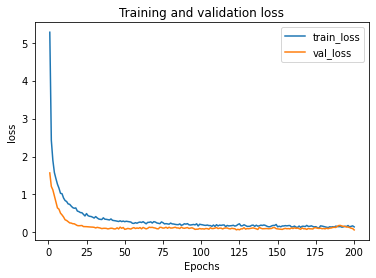

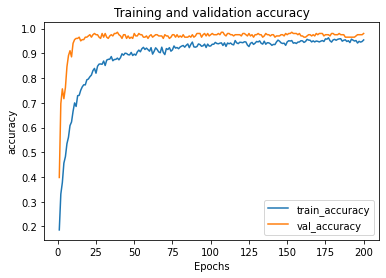

In [18]:
def show_val_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_' + metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation ' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric, 'val_' + metric])
    plt.show()

show_val_metric(model_history, 'loss')
show_val_metric(model_history, 'accuracy')

### Convert and save tflite model

In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
ct = time.strftime("%Y%m%d-%H%M%S")
open("models/converted_model{}.tflite".format(ct), "wb").write(tflite_model)
print("Done")

INFO:tensorflow:Assets written to: C:\Users\CYBERS~1\AppData\Local\Temp\tmpbrne_k_m\assets


Done


## Testing model

In [23]:
loss, accuracy = model.evaluate(processed_X_test, y_test, verbose = 0)
print("=====================Loss=======================")
print('Loss : ', loss)
print("Accuracy : ", accuracy)

y_test_pred_model = model.predict(processed_X_test)
y_test_pred = np_utils.to_categorical(np.argmax(y_test_pred_model, axis=1))

print("=====================Accuracy=======================")
print(accuracy_score(y_test, y_test_pred))

print("=====================Classification Report=======================")
print(classification_report(y_test, y_test_pred, target_names = labels_list))

print("=====================Confusion Matrix=======================")
y_pred_classes = [labels_list[i] for i in np.argmax(y_test_pred_model, axis=1)]
y_test_classes = [labels_list[i] for i in np.argmax(y_test, axis=1)]

con_matrix = confusion_matrix(y_test_classes, y_pred_classes, labels=labels_list)
print(con_matrix)

=====================Loss=======================
Loss :  0.09357424080371857
Accuracy :  0.96517413854599
=====================Accuracy=======================
0.9651741293532339
=====================Classification Report=======================
                       precision    recall  f1-score   support

adho_mukha_shvanasana       1.00      1.00      1.00        27
         bhujangasana       0.95      1.00      0.97        18
           bidalasana       0.96      0.93      0.95        28
          phalakasana       1.00      0.94      0.97        18
            ustrasana       0.95      1.00      0.97        18
           utkatasana       0.94      1.00      0.97        17
      utkata_konasana       1.00      0.90      0.95        10
     virabhadrasana_i       0.92      1.00      0.96        23
    virabhadrasana_ii       0.96      1.00      0.98        24
          vrikshasana       1.00      0.83      0.91        18

            micro avg       0.97      0.97      0.97       20